In [1]:
from IPython.display import display, HTML
display(HTML("<style>.container { width:70% !important; }</style>"))
import numpy as np  # NumPy for numerical operations
import matplotlib.pyplot as plt  # Matplotlib for plotting
from mpl_toolkits.basemap import Basemap  # Basemap for creating geographic plots
from scipy.io.netcdf import NetCDFFile
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import numpy as np
from sklearn.cluster import KMeans
from collections import Counter

C:\Users\jomuel001\AppData\Local\Temp\ipykernel_14332\3029805896.py:6: DeprecationWarning: Please use `NetCDFFile` from the `scipy.io` namespace, the `scipy.io.netcdf` namespace is deprecated.
  from scipy.io.netcdf import NetCDFFile


In [2]:
def einlesen(area, nc):
    if area=="ATLANTIC":
        #path_climatology = r"N:/atm_glomod/user/jomuel001/CMIP6_models_prec/"+model+"/prec_ERA5_1985-2014.N_mjjaso_remapbnds.nc"
        fig = plt.figure(figsize=(8, 8))

        map = Basemap(projection='npstere', boundinglat=30, lon_0=0, llcrnrlon=-90, urcrnrlon=90)
        #nc_climatology = NetCDFFile(path_climatology)
        #print(nc)
        #nc
    
        lat = nc.variables['lat'][:54]
        lon = nc.variables['lon'][:]
        reduced_lon = lon[:80]
        lon = np.concatenate((reduced_lon, lon[-80:]), axis=0)
        time = nc.variables['time'][:]
        var = nc.variables['MSL'][:] # zonal wind
        reduced_var = var[:, :54, :80]
        var = np.concatenate((reduced_var, var[:, :54, -80:]), axis=2)
        print("einlesen fertig")
        # Your data (var) and any preprocessing if needed
        data = var
        flattened_data = data.reshape(data.shape[0], -1)
        data_normalized = (flattened_data - flattened_data.min()) / (flattened_data.max() - flattened_data.min())
        return data_normalized, lon, lat, var
    elif area=="ARCTIC":
        #path_climatology = r"N:/atm_glomod/user/jomuel001/CMIP6_models_prec/"+model+"/prec_ERA5_1985-2014.N_mjjaso_remapbnds.nc"
        fig = plt.figure(figsize=(8, 8))

        map = Basemap(projection='npstere', boundinglat=60, lon_0=0, llcrnrlon=-90, urcrnrlon=90)
        #nc_climatology = NetCDFFile(path_climatology)
        #print(nc)
        #nc

        lat = nc.variables['lat'][:28]
        lon = nc.variables['lon'][:]

        time = nc.variables['time'][:]
        var = nc.variables['MSL'][:] # zonal wind
        var = var[:, :28, :]
        lr = LR  # Learning rate
        sigma = SIGMA  # Sigma parameter
        num_iter = NUM_ITER  # Number of iterations
        print("einlesen fertig")
        # Your data (var) and any preprocessing if needed
        data = var
        flattened_data = data.reshape(data.shape[0], -1)
        data_normalized = (flattened_data - flattened_data.min()) / (flattened_data.max() - flattened_data.min())
        return data_normalized, lon, lat, var

In [63]:
# Define the dimensions of your input and output
def autoencoder_cluster(data_normalized,epochs,batch_size):
    input_dim = data_normalized.shape[1]
    output_dim = 5
    
    # Create the autoencoder model
    model = keras.Sequential([
        keras.layers.Input(shape=input_dim),

        # Encoder
        keras.layers.Dense(64, activation='relu'),
        keras.layers.Dense(32, activation='relu'),

        # Bottleneck layer (5 units)
        keras.layers.Dense(output_dim, activation='relu'),

        # Decoder
        keras.layers.Dense(32, activation='relu'),
        keras.layers.Dense(64, activation='relu'),

        # Output layer
        keras.layers.Dense(input_dim, activation='sigmoid')
    ])

    # Compile the model
    model.compile(optimizer='adam', loss='mean_squared_error')
    model.fit(data_normalized, data_normalized, epochs=epochs, batch_size=batch_size)
    # Display the model summary
    model.summary()
    encoded_data = model.predict(data_normalized)
    print(np.shape(encoded_data))
    # Assuming you want 5 clusters

    n_clusters = 5
    kmeans = KMeans(n_clusters=n_clusters, init="k-means++", n_init=20)

    cluster_labels = kmeans.fit_predict(data_normalized)
    time_parameters = np.arange(5520)  # Assuming you have 5520 time parameters
    time_cluster_mapping = np.column_stack((time_parameters, cluster_labels))

    # Save the time-cluster mapping to a text file
    np.savetxt(path+"AREA.-90_90_89.7849_29.0866\CLUSTER\AUTOENC_slp_hpa_ERA5_1985-2014_mjjaso_atrbg_aacrm21_remapbnds_unnorm_5tabcluster_10PC_dates.txt", time_cluster_mapping, fmt='%d', delimiter='\t')

    cluster_frequencies = Counter(cluster_labels)
    print(cluster_frequencies)
    
    return time_cluster_mapping, cluster_frequencies, epochs, batch_size

In [61]:
def plotten(a,b,var,cluster_frequencies,epochs, batch_size,PLOTTEN):
    datesfile=path+"AREA.-90_90_89.7849_29.0866\CLUSTER\AUTOENC_slp_hpa_ERA5_1985-2014_mjjaso_atrbg_aacrm21_remapbnds_unnorm_5tabcluster_10PC_dates.txt"      
    dates=np.loadtxt(datesfile)
    cluster=dates[:5520,1] # weil auch zukunft in dem ding drin ist
    cluster_numbers = np.linspace(0,b*a-1,b*a)
    iteration=0
    while PLOTTEN and iteration==0:
        print("PLOTTEN findet statt")
        FONTSIZE = 18
        lons,lats = np.meshgrid(lon,lat)
        # Loop through the cluster numbers
        num_rows = b
        num_cols = a
        # Create a single figure to contain all the plots
        fig, axes = plt.subplots(num_rows, num_cols, figsize=(16, 5))  # Adjust figsize as needed

        # Loop through the cluster numbers
        for i, cluster_number in enumerate(cluster_numbers):
            map = Basemap(projection='npstere', boundinglat=30, lon_0=0, llcrnrlon=-90, urcrnrlon=90)
            x,y = map(lons,lats)
            nc = NetCDFFile(path + path_file)
            # Create a filter for the current cluster number
            cluster_filter = [x == cluster_number for x in cluster]
            FONTSIZE = 18
            # Calculate the mean for the current cluster
            soms = np.mean(var[cluster_filter, :, :], axis=0)

            # Define levels and boundaries
            levels = np.array([-15, -10, -7, -5, -3, -1, 1, 3, 5, 7, 10, 15])
            boundaries = np.linspace(-0, 0.1, 13)

            row_index = i // num_cols  # Integer division to determine row
            col_index = i % num_cols 
            print(row_index, col_index)
            # Create the contour plot in the corresponding subplot
            # Create the contour plot in the corresponding subplot
            ax = axes[row_index, col_index] if num_rows > 1 else axes[col_index]
            variable = map.contourf(x, y, soms[:54, :], cmap="seismic", levels=levels, zorder=5, extend='both', ax=ax)
            cb = map.colorbar(variable, ax=ax, fraction=0.05, pad=0.08, ticks=[-15, -10, -7, -5, -3, -1, 1, 3, 5, 7, 10, 15])

            # Customize the colorbar
            for t in cb.ax.get_xticklabels():
                t.set_fontsize(18)
            cb.set_ticklabels(["-15", "-10", "-7", "-5", "-3", "-1", "1", "3", "5", "7", "10", "15"])

            # Customize the plot title and labels
            if num_rows > 1:
                axes[row_index, col_index].set_title(f'ENC Cluster {cluster_number+1}')
            else:
                axes[col_index].set_title(f'ENC Cluster {cluster_number+1}, {round(cluster_frequencies[col_index]/5520,2)}')
            cb.set_label('slp [hPa]', fontsize=18)

            # Draw coastlines and countries
            ax = axes[row_index, col_index] if num_rows > 1 else axes[col_index]
            map.drawcoastlines(linewidth=0.3, zorder=6, ax=ax)
            map.drawcountries(linewidth=0.1, zorder=7, ax=ax)
        for i in range(len(cluster_numbers), num_rows * num_cols):
            if num_rows > 1:
                fig.delaxes(axes[i // num_cols, i % num_cols])
            else:
                fig.delaxes(axes[i])
        # Adjust spacing between subplots
        plt.tight_layout()

        # Save the figure
        plt.savefig(f'N:/atm_glomod/user/jomuel001/CMIP6_models/ERA5/AREA.-90_90_89.7849_29.0866/CLUSTER/PLOTS/AUTOENC_slp_hpa_ERA5_1985-2014_mjjaso_atrbg_aacrm21_remabbnds_unnorm_{len(cluster_numbers)}cluster_10PC_{epochs}epoch_{batch_size}batch_size.png', dpi=300)

        # Display the plot (optional)
        plt.show()
        iteration+=1


44/44 [==============================] - 2s 31ms/step - loss: 0.0083
Model: "sequential_16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_96 (Dense)            (None, 64)                553024    
                                                                 
 dense_97 (Dense)            (None, 32)                2080      
                                                                 
 dense_98 (Dense)            (None, 5)                 165       
                                                                 
 dense_99 (Dense)            (None, 32)                192       
                                                                 
 dense_100 (Dense)           (None, 64)                2112      
                                                                 
 dense_101 (Dense)           (None, 8640)              561600    
                                                  

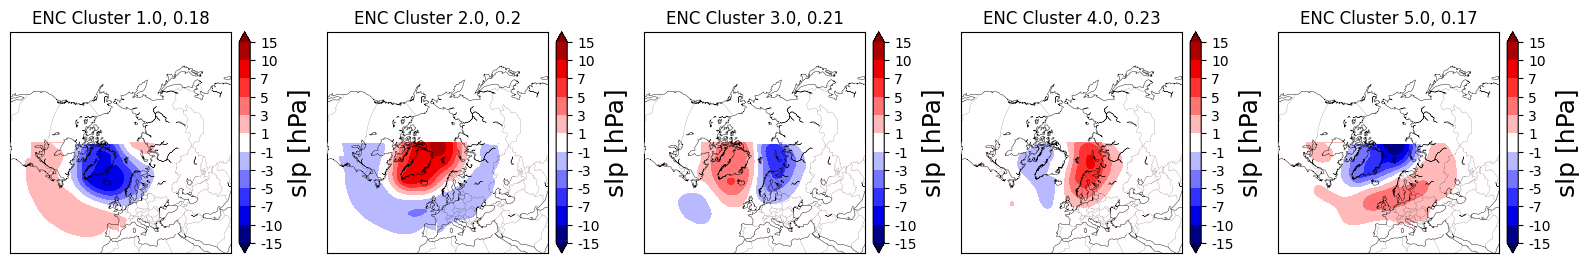

In [64]:
# Assuming data_normalized and labels are your input data and corresponding labels
AREA="ATLANTIC"
path = r"N:/atm_glomod/user/jomuel001/CMIP6_models/ERA5/"
path_file = r"slp_hpa_ERA5_1985-2014.N_mjjaso_atrbg_aacrm21_remapbnds.nc"
epochs=1
batch_size=128
#nc = NetCDFFile(path+path_file)
#data_normalized, lon, lat, var = einlesen(AREA, nc)

mapping,cluster_frequencies, epochs, batch_size = autoencoder_cluster(data_normalized, epochs, batch_size)

plotten(5,1,var,cluster_frequencies,epochs, batch_size,PLOTTEN=True)







In [33]:
cluster_frequencies[0]

710

In [49]:
encoded_data

NameError: name 'encoded_data' is not defined